## Demo: Create animation of daily SST images from MUR SST dataset, overlayed with sla contours 

### Import Packages 

In [1]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

### Load MUR SST datast and SLA data from marn5895 shared space

In [2]:
# 2.2 load the MUR SST dataset from PODAAC thredds server 
PODAAC_url = ('https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc')
full_sst = xr.open_dataset(PODAAC_url)
full_sst

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 7126)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2021-12-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [3]:
# the sla data is daily and contains the dates 2020-01-11 to 2020-03-10
sla = xr.open_dataset('/shared/marn5895/data/MackenzieShannonProject/sla.nc')

In [4]:
sla

<xarray.Dataset>
Dimensions:    (time: 60, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-11 2020-01-12 ... 2020-03-10
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) float64 ...
    lat_bnds   (time, latitude, nv) float32 ...
    lon_bnds   (time, longitude, nv) float32 ...
    err        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

note that the longitude ranges from (0,360) in the sla dataset and from (-180,180) in the MUR SST dataset. In order to work with these datasets together, they must have the same longitude range. We will convert sla longitude from (0,360) to (-180,180)

In [5]:
# longitude conversion 
sla = sla.assign_coords(longitude=((sla.longitude + 180) % 360 - 180))

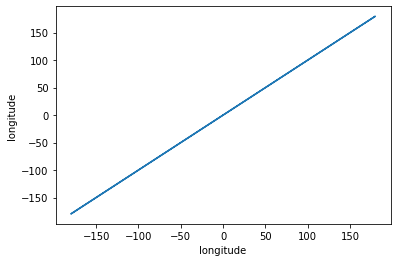

In [6]:
# verification 
sla.longitude.plot()

### Slice the datasets to the ATOMIC sampling region 

In [7]:
# slice to atmoic area 
sla = sla.sel(longitude=slice(-62.125,-48.125),latitude=slice(4,14))

In [8]:
# slice dataset for ATOMIC region 
ATOMIC_sst = full_sst.sel(lon=slice(-62,-48),lat=slice(4,14))

In [10]:
# Select which dates for MUR SST dataset  
sst = ATOMIC_sst.sel(time=slice('2021-01-11T09:00:00.000000000',
                                '2021-03-10T09:00:00.000000000')).analysed_sst

#### sst is in deg K, let's convert this to deg C 

In [11]:
# convert sst to deg C
sst = sst-273.15

### Create an animation of MUR SST overlayed with sla contours 

In [13]:
for i in range(len(sst.time)):         # loop through time to make plot for each time step
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    im = sst.isel(time=i).plot(cmap='cmo.thermal',label='Sea Surface Temperature [Deg C]',
                               cbar_kwargs={'label':'Sea Surface Temperature [Deg C]'}) #plotting sst
    plt.contour(sla.isel(time=i).longitude,
                sla.isel(time=i).latitude,
                sla.isel(time=i).sla,colors='k')  #plotting contours of sla
    title=str(sst.isel(time=i).time.values)[:10]
    plt.savefig('/shared/marn5895/data/MackenzieShannonProject/figs2movie/'+title+'.png') #saving each fig
    plt.close('all') #closing all figs 

### Convert figures in .png format to a single gif 

In [15]:
!convert -delay 15 -loop 0 /shared/marn5895/data/MackenzieShannonProject/figs2movie/*.png /shared/marn5895/data/MackenzieShannonProject/figs2movie/MUR_SST.gif

You can secure file transfer the gif to your local computer using the scp command on your local terminal (*Not HPC*). 
To copy the gif type "scp yournetID@login.storrs.hpc.uconn.edu:/path/to/file/on/hpc /path/to/local/directory"


For example my command looked like "scp mlb15109@login.storrs.hpc.uconn.edu:/shared/marn5895/data/MackenzieShannonProject/figs2movie/MUR_SST.gif /Users/mackenzie/Documents/coursework/MARN5895"


You can then open the gif in google chrome or another application 